# Loop-Shaping - back to feedback equation. 

So far have looked at increasing system performance, but what about the other advantages of control? (disturbance rejection and robustness)?

# Balancing Priorities

$$\varepsilon(s) =S(s)r(s) + T(s)n(s) - S(s)P(s)d(s)$$

Ideally, we would like both $S$ and $T$ to be small so that we have good reference tracking, disturbance rejection and noise rejection. 

Recall: this is not possible since $S(s) + T(s) = 1$, so a reduction in $S$ necessarily means an increase in $T$. 

# Key Insignt 1:  
take a frequency domain point of view!

$$
\begin{align*}
S(j \omega) + T(j \omega) = 1
\end{align*}
$$

This equation still must hold, but importantly it must hold at every frequency.

# Key Insight 2:

For many applications:
- references are low frequency signals,
- disturbances are relatively low frequency,
- measurement noise (sensor noise) is high frequency.

Text(0.5, 80.7222222222222, 'Frequency (Hz)')

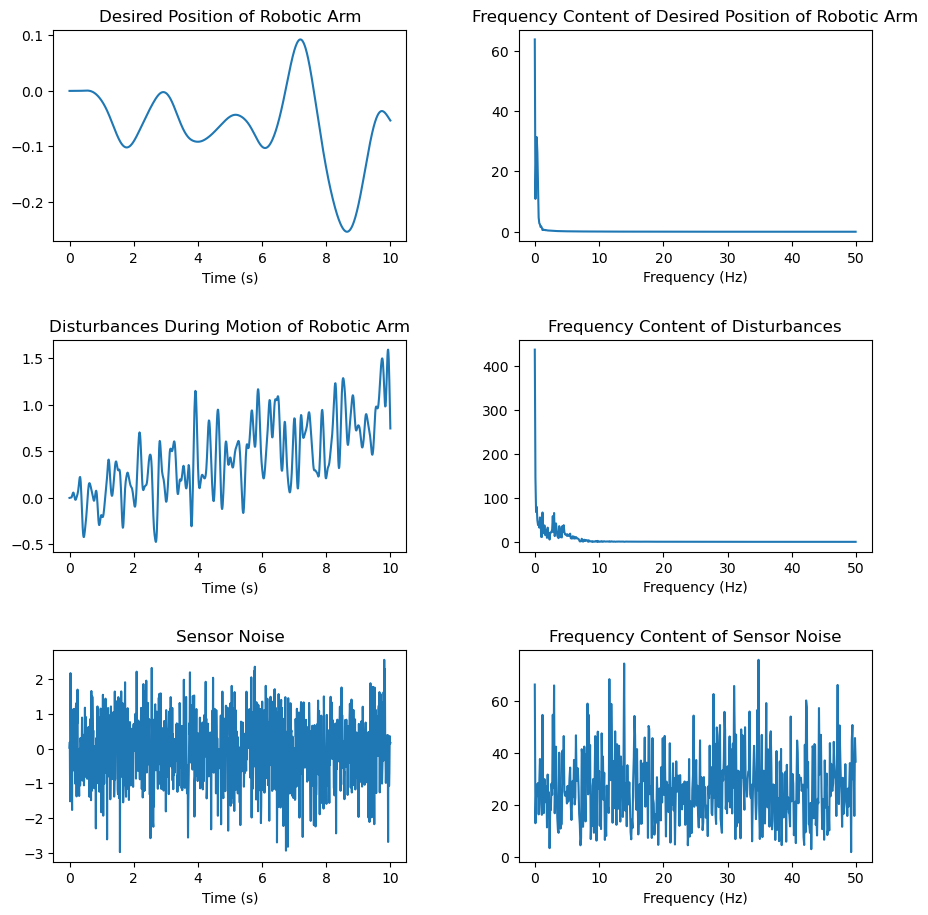

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

N = 1000
t = np.linspace(0,10,N)
rr = np.random.randn(N)
b, a = sp.signal.butter(5, 0.01, 'low')
lp_ref = sp.signal.lfilter(b, a, rr)
LP_ref = abs(sp.fft.fft(lp_ref))
w_ref = sp.fft.fftfreq(N,1/100)

b, a = sp.signal.butter(5, 0.1, 'low')
lp_dis = sp.signal.lfilter(b, a, rr)
lp_dis += np.linspace(0,1,N)
LP_dis = abs(sp.fft.fft(lp_dis))

RR = abs(sp.fft.fft(rr))

fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.tight_layout(pad=5)

ax[0,0].plot(t,lp_ref)
ax[0,0].set_title('Desired Position of Robotic Arm')
ax[0,0].set_xlabel('Time (s)')

ax[0,1].plot(w_ref[0:int(N/2)],LP_ref[0:int(N/2)])
ax[0,1].set_title('Frequency Content of Desired Position of Robotic Arm')
ax[0,1].set_xlabel('Frequency (Hz)')

ax[1,0].plot(t,lp_dis)
ax[1,0].set_title('Disturbances During Motion of Robotic Arm')
ax[1,0].set_xlabel('Time (s)')

ax[1,1].plot(w_ref[0:int(N/2)],LP_dis[0:int(N/2)])
ax[1,1].set_title('Frequency Content of Disturbances')
ax[1,1].set_xlabel('Frequency (Hz)')

ax[2,0].plot(t,rr)
ax[2,0].set_title('Sensor Noise')
ax[2,0].set_xlabel('Time (s)')

ax[2,1].plot(w_ref[0:int(N/2)],RR[0:int(N/2)])
ax[2,1].set_title('Frequency Content of Sensor Noise')
ax[2,1].set_xlabel('Frequency (Hz)')

# Combine insights:

- For low frequencies, want good reference tracking and good disturbance rejection
- For high frequencies, want good sensor noise rejection

In otherwords:
- For low frequencies, want $S$ to be small
- For high frequencies, want $T$ to be small

The trade off:
- For low frequencies, want $S$ to be small (so $T$ will be large, but sensor noise has small power in this frequency range)
- For high frequencies, want $T$ to be small (so $S$ will be large, but references and disturbances have small power in this frequency range)


# That is great insight!

So I want to design the sensitivity and complimentary sensitivity functions so that they have this shape. 

How do we do this? Our ''tuning knob'' is the controller K...

![FrequencyDomainRepresentationDesiredSensitivity](sensitivityBode.png "Frequency Domain Representation of Desirable Sensitivity Function")

In [ ]:
# code for the plot above. No need to run.

import control as ct
import matplotlib.pyplot as plt
import math

s = ct.tf([1, 0], 1)

L = 1/s

S = 1/(1+L)
T = L/(1+L) 
mag, phase, omega = ct.bode([S, T], dB=True, plot=False)

fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Desired Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Desired Complementary Sensitivity Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
plt.show()

# How does $K$ affect frequency response of $S$ and $T$?

$$
\begin{align}
S(s) &= \frac{1}{1+L(s)}  = \frac{1}{1+P(s)K(s)} \\
T(s) &= \frac{L(s)}{1+L(s)} = \frac{P(s)K(s)}{1+P(s)K(s)}  
\end{align}
$$

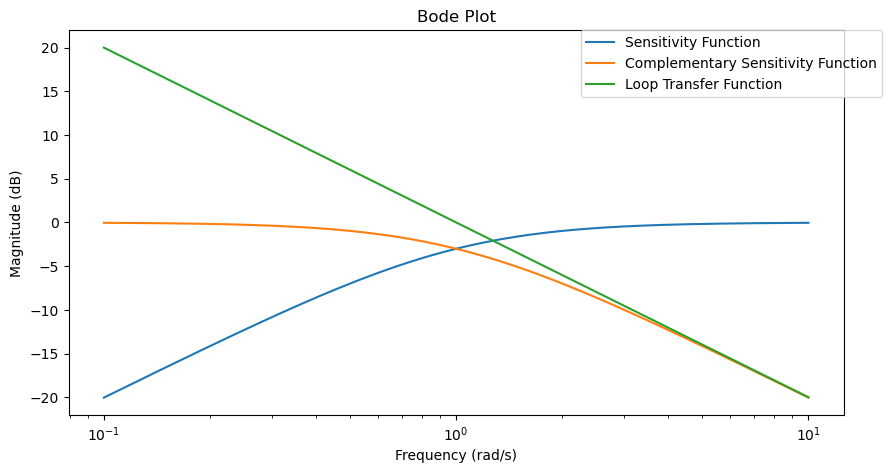

In [2]:
# code for the plot above. No need to run.

import control as ct
import matplotlib.pyplot as plt
import math

s = ct.tf([1, 0], 1)

L = 1/s

S = 1/(1+L)
T = L/(1+L)
mag, phase, omega = ct.bode([S, T, L], dB=True, plot=False)



fig, ax = plt.subplots(1,1, figsize = [10,5])
ax.semilogx(omega[0],[20*math.log10(x) for x in mag[0]], label='Sensitivity Function')
ax.semilogx(omega[1],[20*math.log10(x) for x in mag[1]], label='Complementary Sensitivity Function')
ax.semilogx(omega[2],[20*math.log10(x) for x in mag[2]], label='Loop Transfer Function')
#ax.semilogx(omega[0],mag[0], label='Sensitivity Function')
#ax.semilogx(omega[1],mag[1], label='Complementary Sensitivity Function')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bode Plot')
plt.legend(bbox_to_anchor=(1.05,1), borderaxespad=0)
#ax.grid(True)
plt.show()

![FrequencyDomainRepresentationDesiredLoop](desiredLoopTF.png "Frequency Domain Representation of Desirable Loop Function")

# Let's design $K$! (Idea 2)

One possible loop transfer function that has our desired behavior:

$$L(s) = \frac{k_{\ell}}{s}$$

# In Class Activity!

Prove that a loop transfer function of $\frac{k_{\ell}}{s}$ has the desired properties. Prove it by sketching the magnitude portion of the Bode plot for both $S$ and $T$.

Sketch Bode plot of Sensitivity function when $L(s) = \frac{k_{\ell}}{s}$. Expression for $S$:

$$
\begin{align*}
S(s) &= \frac{1}{1 + L(s)} \\
&= \frac{1}{1 + \frac{k_{\ell}}{s}} \\
&= \frac{s}{s+k_{\ell}}
\end{align*}
$$

What does the Bode plot look like for this function?

Sketch Bode plot of Complimentary Sensitivity function when $L(s) = \frac{k_{\ell}}{s}$. Expression for $T$:

$$
\begin{align*}
T(s) &= \frac{L(s)}{1 + L(s)} \\
&= \frac{\frac{k_{\ell}}{s}}{1 + \frac{k_{\ell}}{s}} \\
&= \frac{k_{\ell}}{s+k_{\ell}}
\end{align*}
$$

What does the Bode plot look like for this function?


# So, $L(s) = \frac{k_{\ell}}{s}$ is our desired loop transfer function. 

# Next step, design $K(s)$ so that we obtain our desired loop transfer function!

We will consider two cases:

- we have a model of the plant,
- we have a Bode plot of the plant

# Example 1 : given a plant transfer function

Suppose that we have a model $P(s)$ for a plant. Then we can write:

$$
\begin{align*}
L(s) &= P(s)K(s) \\
\frac{k_{\ell}}{s} &= P(s)K(s) \\
K(s) &= \frac{k_{\ell}}{s P(s)}
\end{align*}
$$


Caution! We are inverting the plant transfer function. This means that $P(s)$ cannot have any non-minimum phase zeros! Why?

# How to choose $k_{\ell}$?

Need to look at bandwidth of (typical) reference signal and (typical) sensor noise.

Text(0, 0.5, 'Magnitude (dB)')

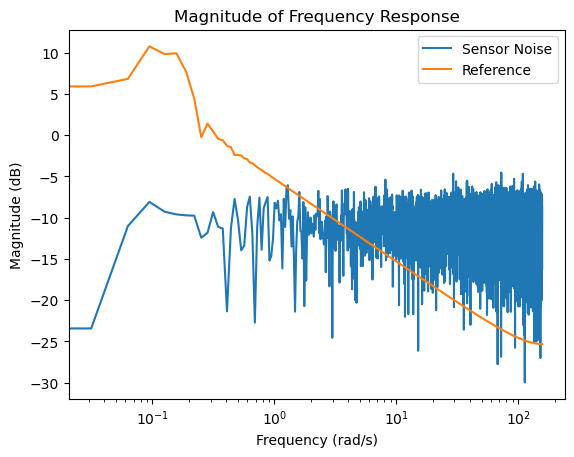

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import enel441_utilities as eu

N = 10000
t = np.linspace(0,100,N)
rr = np.random.randn(N)
B1, A1 = sp.signal.butter(5, 0.001, 'low')
r = 100*sp.signal.lfilter(B1, A1, rr)

B2, A2 = sp.signal.butter(5, 0.1, 'low')
d = sp.signal.lfilter(B2, A2, rr)
d += np.linspace(0,1,N)

n = rr

w = sp.fft.fftfreq(N,1/100)*math.pi

NN = abs(sp.fft.fft(n))
DD = abs(sp.fft.fft(d))
RR = abs(sp.fft.fft(r))

fig, ax = plt.subplots(1)

ax.semilogx(w[0:int(N/2)],10*np.log10(NN[0:int(N/2)]/1000), label='Sensor Noise')
ax.semilogx(w[0:int(N/2)],10*np.log10(RR[0:int(N/2)]/1000), label='Reference')
ax.legend()
ax.set_title('Magnitude of Frequency Response')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')


# Based on this plot, choose $k_{\ell} = 1$. 

Let's look at the 2 disk system again.

![2 Disk Graphic Diagram](2diskGraphic.png "2 Disk Graphic Diagram")

We had determined that the transfer function from motor torque to the position of the second disk is:
$$
\begin{align*}
\frac{\Theta(s)}{T_M(s)} = \frac{1}{ \frac{J_1J_2}{k}s^4 + \frac{J_1b + J_2b}{k}s^3 + (J_1 + J_2 + \frac{b^2}{k}) s^2 + 2bs}  
\end{align*}
$$

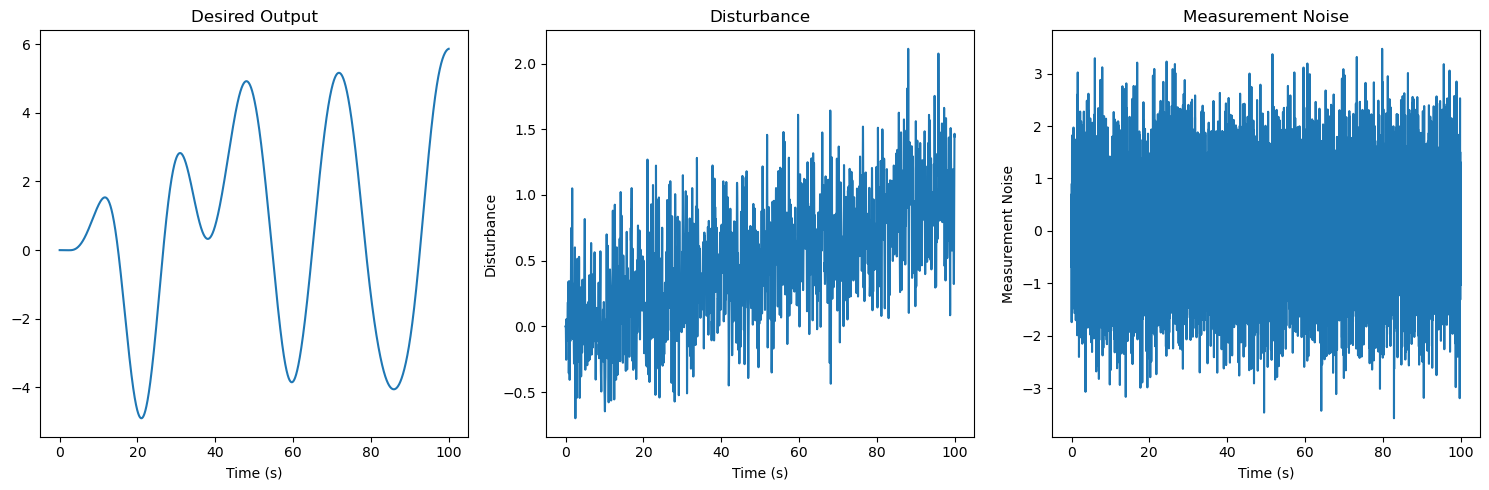

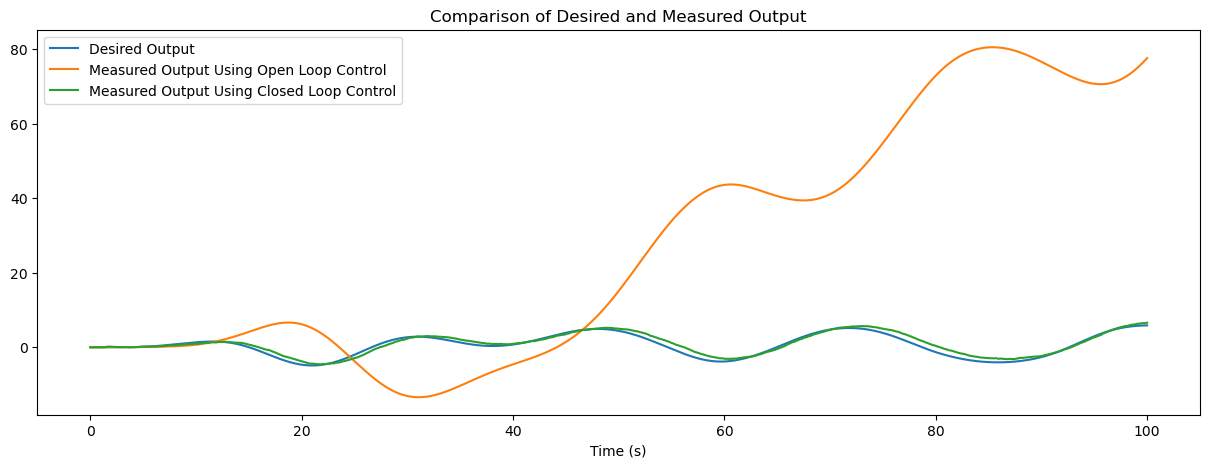

In [7]:
# set system parameters
J1 = 2
J2 = 5
k = 1
b = 0.5

# transfer function numerator and denominator (from equations)
P_num = np.array([1])
P_den = np.array([J1*J2/k, (J1+J2)*b/k, (J1+J2+b**2/k), 2*b, 0])

k_ell = 1
K_num = P_den*k_ell
K_den = np.array([1, 0])

K = ct.tf(K_num, K_den)
P = ct.tf(P_num, P_den)

S = 1/(1+P*K)
T = P*K/(1 + P*K)



# Simulate closed-loop response
t, y_cl_r = ct.forced_response(T,t,r) 
t, y_cl_n = ct.forced_response(T,t,n) 
t, y_cl_d = ct.forced_response(P*S,t,d) 

y_cl = y_cl_r + y_cl_d + y_cl_n


# Simulate open-loop response 
t, y_ol_r = ct.forced_response(P,t,r) 
t, y_ol_d = ct.forced_response(P,t,d) 
y_ol = y_ol_r + y_ol_d 
  
# plot results
eu.enel441_make_open_and_closed_loop_plots(t,r,d,n,y_cl,y_ol)

# Look at frequency domain 

c:\Users\Arne\miniconda3\envs\enel441\lib\site-packages\control\xferfcn.py:401: RuntimeWarning: invalid value encountered in divide
  out[i][j] = (polyval(self.num[i][j], x_arr) /


Text(0, 0.5, 'Magnitude (dB)')

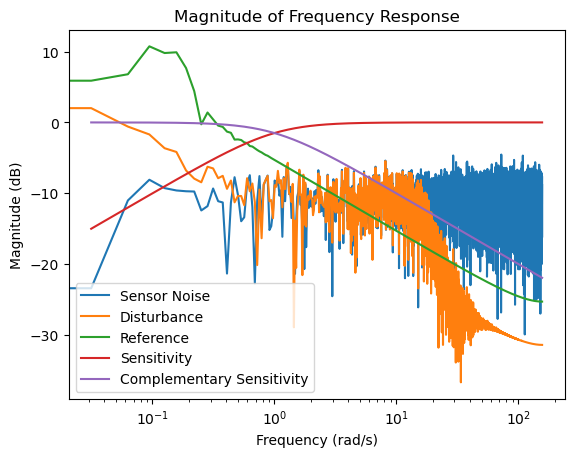

In [8]:
w = sp.fft.fftfreq(N,1/100)*math.pi

NN = abs(sp.fft.fft(n))
DD = abs(sp.fft.fft(d))
RR = abs(sp.fft.fft(r))

S_mag, S_phase, S_w = ct.bode(S, plot=False, omega=w)
T_mag, T_phase, T_w = ct.bode(T, plot=False, omega=w)

fig, ax = plt.subplots(1)

ax.semilogx(w[0:int(N/2)],10*np.log10(NN[0:int(N/2)]/1000), label='Sensor Noise')
ax.semilogx(w[0:int(N/2)],10*np.log10(DD[0:int(N/2)]/1000), label='Disturbance')
ax.semilogx(w[0:int(N/2)],10*np.log10(RR[0:int(N/2)]/1000), label='Reference')
ax.plot(S_w, 10*np.log10(S_mag), label='Sensitivity')
ax.plot(T_w, 10*np.log10(T_mag), label='Complementary Sensitivity')
ax.legend()
ax.set_title('Magnitude of Frequency Response')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude (dB)')


# Example 2: given a Bode plot of plant

Often it is possible to obtain a Bode Plot of a system from data (no need to model the system using equations). In this situation, we can use a graphical loop-shaping approach.

In [ ]:
import control as ct

P = ct.tf(1,[1, 2, 5])
mag,phase,w=ct.bode(P)

Strategy: Visually try to place poles and zeros such that the Magnitude response of $P(s)K(s)$ looks like $\frac{k_{\ell}}{s}$.

Suppose we have selected $k_{\ell} = 1$ based on the typical reference signal bandwidth.

For the plot shown above we see that there are two complex conjugate poles with real part $\alpha \approx 2$. So place two zeros at $-2$. Then the controller becomes:

$$ K= \frac{(s+2)^2}{s} $$

The Bode plot of the resulting loop transfer function is:


In [ ]:
K = ct.tf([1, 4, 4], [1, 0])
mag,phase,w=ct.bode(P*K)

And the Bode plot of the Sensitivity and Complementary Sensitivity Function are:

In [ ]:
mag,phase,w=ct.bode(1/(1 + P*K))
mag,phase,w=ct.bode(P*K/(1 + P*K))


Although these plots don't look quite as nice as the previous ones, they do have the main feature that $S(j \omega)$ is small for $0 - 1$ rad/s, and $T(j \omega)$ is small for $1-10$ rad/s.

# End of Unit 2 - Introduction to Control

# Summary of important topics:
- Feedback equation
- Advantages of control:
    - Increase performance
    - Disturbance Rejection
    - Robustness to modelling errors/changes in the model
- Open loop vs. closed loop system and corresponding transfer function
- Sensitivity Function
    - determines tracking error
- Complementary Sensitivity Function
    - transfer function from reference to output
    - governs measurement noise rejection
- Proportional Control - Choose $K$ equal to a constant
    - Attempt to make $S$ small by increasing $K$
    - Can change step response characteristics
    - Problems with steady state errors (can be very large)
- Root Locus - map closed-loop poles that are possible for a proportional controller onto s-plane
- Loop-Shaping
    - Shape Sensitivity and Complementary Sensitivity Functions per frequency to obtain satisfactory reference tracking and measurement noise rejection
    - One attractive loop transfer function is $\frac{k_{\ell}}{s}$. Can design $K$ to achieve this loop transfer function.